Importing Libraries and Packages:

In [1]:
!pip install tensorflow
!pip install optuna
import tensorflow as tf
import struct
import os
import logging
import optuna
import optuna.visualization as vis
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, LeakyReLU, Activation, Dropout , Conv2D ,Conv2DTranspose , BatchNormalization ,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import numpy as np

# Set TensorFlow logging level to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set logging level to suppress TensorFlow warnings except for critical ones
tf.get_logger().setLevel(logging.ERROR) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Loading, Preprocessing & Splitting Data**

In [3]:
#Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Concatenate images and labels
all_images = np.concatenate((x_train, x_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# scalling
all_images = all_images.reshape(all_images.shape[0], 28, 28, 1)
all_images = all_images.astype('float32')
all_images = all_images / 255.0

#Split into training,validation and test datasets in 70 , 15 and 15 %
train_X,rem_X,train_Y,rem_Y = train_test_split(all_images,all_labels,test_size=0.3,random_state=13)
val_X,test_X,val_Y,test_Y = train_test_split(rem_X,rem_Y,test_size=0.5,random_state=13)

11490434/11490434 [==============================] - 1s 0us/step


# **Building the Autoencoder Model :**

In [4]:
class Autoencoder(Model):
    def __init__(self,latent_dim,conv_layers,kernel_size,filters,shape,dropout_rate):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder_layers = []

        #First layer in decoder has the same dimension as the last layer in encoder (original size halved as many times as we applied upsampling,2 here)
        last_layer = shape[0] // (2 ** 2)

        #The flattened layer will be the inner product of the last layer in encoder that had dimensions (last_layer,last_layer,last filter size)
        flattened_dim = last_layer * last_layer * filters[conv_layers-1]

        self.decoder_layers = [Dense(flattened_dim, activation='relu'),
                               Reshape((last_layer,last_layer,filters[conv_layers-1]))]

        for layer in range(conv_layers) :

          #add the convolutional and maxpooling layer in the encoder's list
          self.encoder_layers.append(Conv2D(filters=filters[layer], kernel_size=kernel_size, activation='relu', padding='same'))
          self.encoder_layers.append(BatchNormalization())
          if(layer < conv_layers - 1) :
            #add the convolutional layer in the decoder's list with the opposite order of the filters
            self.decoder_layers.append(Conv2DTranspose(filters=filters[conv_layers-layer-1], kernel_size=kernel_size, activation='relu', padding='same'))
            self.decoder_layers.append(BatchNormalization())
            #We only apply maxpooling in the first 2 layers because otherwise we can't reconstruct the vector with the appropriate dimensions
            if(layer <=  1) :
                self.encoder_layers.append(MaxPooling2D((2, 2), padding="same"))
                self.decoder_layers.append(UpSampling2D((2, 2), interpolation='nearest'))
            self.decoder_layers.append(Dropout(dropout_rate))

          self.encoder_layers.append(Dropout(dropout_rate))

        self.encoder_layers.append(Flatten())
        self.encoder_layers.append(Dense(self.latent_dim, activation='relu'))

        #In the last layer of the decoder we apply the sigmoid function
        self.decoder_layers.append(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same'))

        self.encoder = tf.keras.Sequential(self.encoder_layers)
        self.decoder = tf.keras.Sequential(self.decoder_layers)

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# **Hyperparameter Tuning:**

In [5]:
# Disable Optuna trial output
optuna.logging.set_verbosity(optuna.logging.WARNING)  

shape = (28,28,1)
predefined_filters =[[32, 64, 128],[32,64,128,256],[16,32,64,128],[16,32,64,128,256]]

def objective(trial):
    epoch = trial.suggest_categorical('epoch',[10,15,20])
    batch = trial.suggest_categorical('batch', [64,128,256])
    dim = trial.suggest_categorical('dim',[5,10,20,30])
    kernel = trial.suggest_categorical('kernel', [(3, 3), (5, 5), (7, 7)])
    filters = trial.suggest_categorical('filters', predefined_filters)
    rate = trial.suggest_categorical('rate', [0.5,0.6,0.7])

    autoencoder = Autoencoder(dim, len(filters), kernel, filters, shape, rate)
    autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = autoencoder.fit(train_X, train_X,
                              epochs=epoch,
                              shuffle=True,
                              batch_size=batch,
                              callbacks=[early_stopping],
                              validation_data=(val_X, val_X))
    val_loss = history.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction='minimize', study_name='my_study_name')
study.optimize(objective, n_trials=25)

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (7, 7) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but conta

Epoch 1/15


2024-01-06 15:53:37.591182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder/sequential/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 16s 19ms/step - loss: 0.0731 - accuracy: 0.7754 - val_loss: 0.0555 - val_accuracy: 0.8059
Epoch 2/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0411 - accuracy: 0.7971 - val_loss: 0.0299 - val_accuracy: 0.8041
Epoch 3/15
383/383 [==============================] - 6s 17ms/step - loss: 0.0330 - accuracy: 0.8020 - val_loss: 0.0227 - val_accuracy: 0.8077
Epoch 4/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0287 - accuracy: 0.8044 - val_loss: 0.0205 - val_accuracy: 0.8100
Epoch 5/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0264 - accuracy: 0.8058 - val_loss: 0.0171 - val_accuracy: 0.8100
Epoch 6/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0243 - accuracy: 0.8070 - val_loss: 0.0153 - val_accuracy: 0.8107
Epoch 7/15
383/383 [==============================] - 6s 16ms/step - loss: 0.0239 - accuracy: 0.8073 - val_loss: 0.0152 - val_accuracy: 0.8110
Epoch 8/1

2024-01-06 15:55:20.513143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_1/sequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 17s 52ms/step - loss: 0.0661 - accuracy: 0.7835 - val_loss: 0.0608 - val_accuracy: 0.8013
Epoch 2/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0382 - accuracy: 0.7999 - val_loss: 0.0346 - val_accuracy: 0.8081
Epoch 3/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0296 - accuracy: 0.8046 - val_loss: 0.0231 - val_accuracy: 0.8111
Epoch 4/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0252 - accuracy: 0.8069 - val_loss: 0.0176 - val_accuracy: 0.8108
Epoch 5/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0235 - accuracy: 0.8077 - val_loss: 0.0175 - val_accuracy: 0.8088
Epoch 6/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0225 - accuracy: 0.8082 - val_loss: 0.0240 - val_accuracy: 0.8033
Epoch 7/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0208 - accuracy: 0.8091 - val_loss: 0.0136 - val_accuracy: 0.8124
Epoch 8/1

2024-01-06 15:57:42.395738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_2/sequential_4/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 13s 17ms/step - loss: 0.0827 - accuracy: 0.7816 - val_loss: 0.0898 - val_accuracy: 0.8083
Epoch 2/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0722 - accuracy: 0.7915 - val_loss: 0.0689 - val_accuracy: 0.8080
Epoch 3/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0616 - accuracy: 0.7928 - val_loss: 0.0532 - val_accuracy: 0.7988
Epoch 4/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0532 - accuracy: 0.7916 - val_loss: 0.0469 - val_accuracy: 0.7935
Epoch 5/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0496 - accuracy: 0.7929 - val_loss: 0.0445 - val_accuracy: 0.7915
Epoch 6/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0464 - accuracy: 0.7942 - val_loss: 0.0404 - val_accuracy: 0.7980
Epoch 7/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0429 - accuracy: 0.7960 - val_loss: 0.0370 - val_accuracy: 0.7985
Epoch 8/2

2024-01-06 15:59:49.860712: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_3/sequential_6/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 17s 14ms/step - loss: 0.0767 - accuracy: 0.7878 - val_loss: 0.0651 - val_accuracy: 0.8077
Epoch 2/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0596 - accuracy: 0.7924 - val_loss: 0.0479 - val_accuracy: 0.7956
Epoch 3/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0496 - accuracy: 0.7943 - val_loss: 0.0392 - val_accuracy: 0.8049
Epoch 4/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0423 - accuracy: 0.7974 - val_loss: 0.0315 - val_accuracy: 0.8053
Epoch 5/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0374 - accuracy: 0.7999 - val_loss: 0.0269 - val_accuracy: 0.8063
Epoch 6/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0342 - accuracy: 0.8016 - val_loss: 0.0240 - val_accuracy: 0.8074
Epoch 7/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0309 - accuracy: 0.8033 - val_loss: 0.0216 - val_accuracy: 0.8095
Epo

2024-01-06 16:02:28.019323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_4/sequential_8/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0663 - accuracy: 0.7880 - val_loss: 0.0505 - val_accuracy: 0.8054
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0474 - accuracy: 0.7961 - val_loss: 0.0338 - val_accuracy: 0.8005
Epoch 3/10
766/766 [==============================] - 13s 16ms/step - loss: 0.0335 - accuracy: 0.8023 - val_loss: 0.0225 - val_accuracy: 0.8104
Epoch 4/10
766/766 [==============================] - 13s 16ms/step - loss: 0.0264 - accuracy: 0.8060 - val_loss: 0.0172 - val_accuracy: 0.8109
Epoch 5/10
766/766 [==============================] - 13s 16ms/step - loss: 0.0228 - accuracy: 0.8078 - val_loss: 0.0148 - val_accuracy: 0.8115
Epoch 6/10
766/766 [==============================] - 13s 16ms/step - loss: 0.0206 - accuracy: 0.8090 - val_loss: 0.0130 - val_accuracy: 0.8123
Epoch 7/10
766/766 [==============================] - 12s 16ms/step - loss: 0.0190 - accuracy: 0.8099 - val_loss: 0.0116 - val_accuracy: 0.8133
Epo

2024-01-06 16:04:40.993158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_5/sequential_10/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 12s 9ms/step - loss: 0.0769 - accuracy: 0.7839 - val_loss: 0.0706 - val_accuracy: 0.8044
Epoch 2/20
766/766 [==============================] - 6s 8ms/step - loss: 0.0525 - accuracy: 0.7925 - val_loss: 0.0470 - val_accuracy: 0.8086
Epoch 3/20
766/766 [==============================] - 6s 8ms/step - loss: 0.0407 - accuracy: 0.7974 - val_loss: 0.0367 - val_accuracy: 0.8084
Epoch 4/20
766/766 [==============================] - 7s 9ms/step - loss: 0.0368 - accuracy: 0.7992 - val_loss: 0.0328 - val_accuracy: 0.8086
Epoch 5/20
766/766 [==============================] - 7s 9ms/step - loss: 0.0322 - accuracy: 0.8017 - val_loss: 0.0249 - val_accuracy: 0.8098
Epoch 6/20
766/766 [==============================] - 6s 8ms/step - loss: 0.0295 - accuracy: 0.8033 - val_loss: 0.0233 - val_accuracy: 0.8105
Epoch 7/20
766/766 [==============================] - 6s 8ms/step - loss: 0.0275 - accuracy: 0.8044 - val_loss: 0.0209 - val_accuracy: 0.8097
Epoch 8/20
766/7

2024-01-06 16:07:06.256896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_6/sequential_12/dropout_41/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 23s 42ms/step - loss: 0.0775 - accuracy: 0.7897 - val_loss: 0.0689 - val_accuracy: 0.8061
Epoch 2/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0648 - accuracy: 0.7933 - val_loss: 0.0585 - val_accuracy: 0.7988
Epoch 3/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0513 - accuracy: 0.7935 - val_loss: 0.0439 - val_accuracy: 0.7964
Epoch 4/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0439 - accuracy: 0.7955 - val_loss: 0.0363 - val_accuracy: 0.7982
Epoch 5/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0357 - accuracy: 0.7999 - val_loss: 0.0293 - val_accuracy: 0.8043
Epoch 6/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0314 - accuracy: 0.8026 - val_loss: 0.0262 - val_accuracy: 0.8070
Epoch 7/20
383/383 [==============================] - 15s 38ms/step - loss: 0.0292 - accuracy: 0.8039 - val_loss: 0.0239 - val_accuracy: 0.8086
Epo

2024-01-06 16:12:06.789610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_7/sequential_14/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 11s 31ms/step - loss: 0.0817 - accuracy: 0.7802 - val_loss: 0.0846 - val_accuracy: 0.8084
Epoch 2/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0560 - accuracy: 0.7915 - val_loss: 0.0448 - val_accuracy: 0.8071
Epoch 3/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0450 - accuracy: 0.7960 - val_loss: 0.0345 - val_accuracy: 0.8044
Epoch 4/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0401 - accuracy: 0.7986 - val_loss: 0.0293 - val_accuracy: 0.8031
Epoch 5/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0376 - accuracy: 0.8004 - val_loss: 0.0285 - val_accuracy: 0.8061
Epoch 6/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0340 - accuracy: 0.8021 - val_loss: 0.0267 - val_accuracy: 0.8085
Epoch 7/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0319 - accuracy: 0.8031 - val_loss: 0.0276 - val_accuracy: 0.8110
Epoch 8/2

2024-01-06 16:14:02.552507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_8/sequential_16/dropout_53/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 16s 14ms/step - loss: 0.0779 - accuracy: 0.7885 - val_loss: 0.0714 - val_accuracy: 0.8081
Epoch 2/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0626 - accuracy: 0.7939 - val_loss: 0.0590 - val_accuracy: 0.8028
Epoch 3/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0569 - accuracy: 0.7937 - val_loss: 0.0519 - val_accuracy: 0.8073
Epoch 4/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0511 - accuracy: 0.7948 - val_loss: 0.0459 - val_accuracy: 0.8061
Epoch 5/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0468 - accuracy: 0.7958 - val_loss: 0.0384 - val_accuracy: 0.8052
Epoch 6/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0414 - accuracy: 0.7974 - val_loss: 0.0342 - val_accuracy: 0.8046
Epoch 7/15
766/766 [==============================] - 10s 13ms/step - loss: 0.0391 - accuracy: 0.7986 - val_loss: 0.0323 - val_accuracy: 0.8052
Epo

2024-01-06 16:16:40.662444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_9/sequential_18/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 17ms/step - loss: 0.0720 - accuracy: 0.7885 - val_loss: 0.0585 - val_accuracy: 0.7992
Epoch 2/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0532 - accuracy: 0.7941 - val_loss: 0.0408 - val_accuracy: 0.8031
Epoch 3/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0431 - accuracy: 0.7975 - val_loss: 0.0309 - val_accuracy: 0.8046
Epoch 4/15
766/766 [==============================] - 13s 16ms/step - loss: 0.0365 - accuracy: 0.8007 - val_loss: 0.0260 - val_accuracy: 0.8065
Epoch 5/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0319 - accuracy: 0.8032 - val_loss: 0.0211 - val_accuracy: 0.8100
Epoch 6/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0282 - accuracy: 0.8052 - val_loss: 0.0178 - val_accuracy: 0.8114
Epoch 7/15
766/766 [==============================] - 13s 17ms/step - loss: 0.0256 - accuracy: 0.8066 - val_loss: 0.0158 - val_accuracy: 0.8111
Epo

2024-01-06 16:20:00.435914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_10/sequential_20/dropout_67/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 38s 39ms/step - loss: 0.0696 - accuracy: 0.7889 - val_loss: 0.0558 - val_accuracy: 0.7950
Epoch 2/10
766/766 [==============================] - 29s 38ms/step - loss: 0.0537 - accuracy: 0.7931 - val_loss: 0.0427 - val_accuracy: 0.8017
Epoch 3/10
766/766 [==============================] - 29s 37ms/step - loss: 0.0438 - accuracy: 0.7968 - val_loss: 0.0377 - val_accuracy: 0.8028
Epoch 4/10
766/766 [==============================] - 29s 38ms/step - loss: 0.0377 - accuracy: 0.7999 - val_loss: 0.0285 - val_accuracy: 0.8049
Epoch 5/10
766/766 [==============================] - 29s 38ms/step - loss: 0.0302 - accuracy: 0.8039 - val_loss: 0.0231 - val_accuracy: 0.8054
Epoch 6/10
766/766 [==============================] - 29s 38ms/step - loss: 0.0260 - accuracy: 0.8062 - val_loss: 0.0181 - val_accuracy: 0.8107
Epoch 7/10
766/766 [==============================] - 29s 38ms/step - loss: 0.0231 - accuracy: 0.8077 - val_loss: 0.0155 - val_accuracy: 0.8113
Epo

2024-01-06 16:24:58.715235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_11/sequential_22/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 20s 33ms/step - loss: 0.0755 - accuracy: 0.7771 - val_loss: 0.0610 - val_accuracy: 0.7887
Epoch 2/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0437 - accuracy: 0.7957 - val_loss: 0.0345 - val_accuracy: 0.8017
Epoch 3/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0347 - accuracy: 0.8009 - val_loss: 0.0263 - val_accuracy: 0.8083
Epoch 4/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0301 - accuracy: 0.8037 - val_loss: 0.0223 - val_accuracy: 0.8096
Epoch 5/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0270 - accuracy: 0.8056 - val_loss: 0.0182 - val_accuracy: 0.8101
Epoch 6/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0263 - accuracy: 0.8059 - val_loss: 0.0176 - val_accuracy: 0.8101
Epoch 7/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0242 - accuracy: 0.8071 - val_loss: 0.0166 - val_accuracy: 0.8117
Epo

2024-01-06 16:27:24.095468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_12/sequential_24/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 30s 58ms/step - loss: 0.0688 - accuracy: 0.7842 - val_loss: 0.0459 - val_accuracy: 0.8005
Epoch 2/10
383/383 [==============================] - 21s 54ms/step - loss: 0.0414 - accuracy: 0.7984 - val_loss: 0.0298 - val_accuracy: 0.8053
Epoch 3/10
383/383 [==============================] - 21s 54ms/step - loss: 0.0351 - accuracy: 0.8016 - val_loss: 0.0276 - val_accuracy: 0.8047
Epoch 4/10
383/383 [==============================] - 21s 55ms/step - loss: 0.0293 - accuracy: 0.8047 - val_loss: 0.0249 - val_accuracy: 0.8045
Epoch 5/10
383/383 [==============================] - 21s 55ms/step - loss: 0.0263 - accuracy: 0.8062 - val_loss: 0.0203 - val_accuracy: 0.8086
Epoch 6/10
383/383 [==============================] - 21s 54ms/step - loss: 0.0237 - accuracy: 0.8075 - val_loss: 0.0179 - val_accuracy: 0.8095
Epoch 7/10
383/383 [==============================] - 21s 54ms/step - loss: 0.0220 - accuracy: 0.8084 - val_loss: 0.0170 - val_accuracy: 0.8109
Epo

2024-01-06 16:31:02.408744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_13/sequential_26/dropout_92/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 12s 17ms/step - loss: 0.0736 - accuracy: 0.7793 - val_loss: 0.0552 - val_accuracy: 0.8087
Epoch 2/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0461 - accuracy: 0.7951 - val_loss: 0.0314 - val_accuracy: 0.8029
Epoch 3/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0371 - accuracy: 0.7999 - val_loss: 0.0270 - val_accuracy: 0.8083
Epoch 4/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0321 - accuracy: 0.8028 - val_loss: 0.0219 - val_accuracy: 0.8090
Epoch 5/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0291 - accuracy: 0.8045 - val_loss: 0.0193 - val_accuracy: 0.8103
Epoch 6/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0270 - accuracy: 0.8056 - val_loss: 0.0176 - val_accuracy: 0.8107
Epoch 7/10
383/383 [==============================] - 6s 16ms/step - loss: 0.0253 - accuracy: 0.8066 - val_loss: 0.0156 - val_accuracy: 0.8109
Epoch 8/1

2024-01-06 16:32:11.052660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_14/sequential_28/dropout_99/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 16s 48ms/step - loss: 0.0796 - accuracy: 0.7820 - val_loss: 0.0745 - val_accuracy: 0.7389
Epoch 2/15
192/192 [==============================] - 9s 46ms/step - loss: 0.0666 - accuracy: 0.7911 - val_loss: 0.0658 - val_accuracy: 0.7993
Epoch 3/15
192/192 [==============================] - 9s 45ms/step - loss: 0.0647 - accuracy: 0.7910 - val_loss: 0.0602 - val_accuracy: 0.8019
Epoch 4/15
192/192 [==============================] - 9s 45ms/step - loss: 0.0601 - accuracy: 0.7914 - val_loss: 0.0570 - val_accuracy: 0.8041
Epoch 5/15
192/192 [==============================] - 9s 45ms/step - loss: 0.0555 - accuracy: 0.7930 - val_loss: 0.0527 - val_accuracy: 0.8075
Epoch 6/15
192/192 [==============================] - 9s 45ms/step - loss: 0.0512 - accuracy: 0.7941 - val_loss: 0.0464 - val_accuracy: 0.8059
Epoch 7/15
192/192 [==============================] - 9s 45ms/step - loss: 0.0470 - accuracy: 0.7954 - val_loss: 0.0417 - val_accuracy: 0.8031
Epoch 8/1

2024-01-06 16:34:29.222443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_15/sequential_30/dropout_106/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 15s 11ms/step - loss: 0.0591 - accuracy: 0.7854 - val_loss: 0.0314 - val_accuracy: 0.8068
Epoch 2/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0320 - accuracy: 0.8027 - val_loss: 0.0196 - val_accuracy: 0.8085
Epoch 3/10
766/766 [==============================] - 8s 10ms/step - loss: 0.0257 - accuracy: 0.8063 - val_loss: 0.0155 - val_accuracy: 0.8106
Epoch 4/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0224 - accuracy: 0.8079 - val_loss: 0.0130 - val_accuracy: 0.8121
Epoch 5/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0202 - accuracy: 0.8091 - val_loss: 0.0116 - val_accuracy: 0.8123
Epoch 6/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0189 - accuracy: 0.8097 - val_loss: 0.0108 - val_accuracy: 0.8129
Epoch 7/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0180 - accuracy: 0.8102 - val_loss: 0.0102 - val_accuracy: 0.8135
Epoch 8/1

2024-01-06 16:35:58.372082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_16/sequential_32/dropout_113/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 32s 34ms/step - loss: 0.0558 - accuracy: 0.7914 - val_loss: 0.0302 - val_accuracy: 0.8052
Epoch 2/10
766/766 [==============================] - 26s 33ms/step - loss: 0.0315 - accuracy: 0.8036 - val_loss: 0.0263 - val_accuracy: 0.8045
Epoch 3/10
766/766 [==============================] - 26s 34ms/step - loss: 0.0263 - accuracy: 0.8064 - val_loss: 0.0238 - val_accuracy: 0.8095
Epoch 4/10
766/766 [==============================] - 26s 34ms/step - loss: 0.0212 - accuracy: 0.8090 - val_loss: 0.0153 - val_accuracy: 0.8108
Epoch 5/10
766/766 [==============================] - 26s 33ms/step - loss: 0.0179 - accuracy: 0.8105 - val_loss: 0.0137 - val_accuracy: 0.8111
Epoch 6/10
766/766 [==============================] - 26s 34ms/step - loss: 0.0161 - accuracy: 0.8113 - val_loss: 0.0112 - val_accuracy: 0.8129
Epoch 7/10
766/766 [==============================] - 26s 34ms/step - loss: 0.0143 - accuracy: 0.8121 - val_loss: 0.0099 - val_accuracy: 0.8135
Epo

2024-01-06 16:40:23.774216: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_17/sequential_34/dropout_120/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0412 - accuracy: 0.7975 - val_loss: 0.0185 - val_accuracy: 0.8112
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0204 - accuracy: 0.8094 - val_loss: 0.0126 - val_accuracy: 0.8122
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0163 - accuracy: 0.8113 - val_loss: 0.0102 - val_accuracy: 0.8132
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0138 - accuracy: 0.8124 - val_loss: 0.0092 - val_accuracy: 0.8135
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0124 - accuracy: 0.8130 - val_loss: 0.0079 - val_accuracy: 0.8140
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0113 - accuracy: 0.8134 - val_loss: 0.0066 - val_accuracy: 0.8145
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0107 - accuracy: 0.8136 - val_loss: 0.0076 - val_accuracy: 0.8141
Epo

2024-01-06 16:42:44.724684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_18/sequential_36/dropout_127/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0426 - accuracy: 0.7961 - val_loss: 0.0207 - val_accuracy: 0.8110
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0224 - accuracy: 0.8082 - val_loss: 0.0161 - val_accuracy: 0.8128
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0182 - accuracy: 0.8103 - val_loss: 0.0125 - val_accuracy: 0.8130
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0160 - accuracy: 0.8114 - val_loss: 0.0111 - val_accuracy: 0.8136
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0145 - accuracy: 0.8120 - val_loss: 0.0095 - val_accuracy: 0.8137
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0134 - accuracy: 0.8124 - val_loss: 0.0085 - val_accuracy: 0.8140
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0124 - accuracy: 0.8129 - val_loss: 0.0081 - val_accuracy: 0.8138
Epo

2024-01-06 16:45:04.697685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_19/sequential_38/dropout_134/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0388 - accuracy: 0.7985 - val_loss: 0.0163 - val_accuracy: 0.8113
Epoch 2/10
766/766 [==============================] - 13s 18ms/step - loss: 0.0189 - accuracy: 0.8101 - val_loss: 0.0115 - val_accuracy: 0.8134
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0154 - accuracy: 0.8117 - val_loss: 0.0099 - val_accuracy: 0.8132
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0134 - accuracy: 0.8126 - val_loss: 0.0089 - val_accuracy: 0.8137
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0121 - accuracy: 0.8130 - val_loss: 0.0095 - val_accuracy: 0.8133
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0113 - accuracy: 0.8134 - val_loss: 0.0081 - val_accuracy: 0.8139
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0106 - accuracy: 0.8136 - val_loss: 0.0067 - val_accuracy: 0.8145
Epo

2024-01-06 16:47:24.946679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_20/sequential_40/dropout_141/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0574 - accuracy: 0.7897 - val_loss: 0.0383 - val_accuracy: 0.8061
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0375 - accuracy: 0.8001 - val_loss: 0.0311 - val_accuracy: 0.8044
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0338 - accuracy: 0.8022 - val_loss: 0.0292 - val_accuracy: 0.8051
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0322 - accuracy: 0.8030 - val_loss: 0.0283 - val_accuracy: 0.8066
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0309 - accuracy: 0.8037 - val_loss: 0.0273 - val_accuracy: 0.8050
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0299 - accuracy: 0.8041 - val_loss: 0.0270 - val_accuracy: 0.8075
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0293 - accuracy: 0.8045 - val_loss: 0.0261 - val_accuracy: 0.8066
Epo

2024-01-06 16:49:50.257864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_21/sequential_42/dropout_148/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0402 - accuracy: 0.7980 - val_loss: 0.0168 - val_accuracy: 0.8110
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0197 - accuracy: 0.8097 - val_loss: 0.0128 - val_accuracy: 0.8128
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0162 - accuracy: 0.8114 - val_loss: 0.0099 - val_accuracy: 0.8133
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0141 - accuracy: 0.8123 - val_loss: 0.0087 - val_accuracy: 0.8138
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0127 - accuracy: 0.8128 - val_loss: 0.0082 - val_accuracy: 0.8145
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0115 - accuracy: 0.8133 - val_loss: 0.0081 - val_accuracy: 0.8138
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0109 - accuracy: 0.8135 - val_loss: 0.0067 - val_accuracy: 0.8144
Epo

2024-01-06 16:52:09.477807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_22/sequential_44/dropout_155/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0405 - accuracy: 0.7978 - val_loss: 0.0181 - val_accuracy: 0.8121
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0188 - accuracy: 0.8102 - val_loss: 0.0128 - val_accuracy: 0.8130
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0155 - accuracy: 0.8117 - val_loss: 0.0096 - val_accuracy: 0.8133
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0136 - accuracy: 0.8125 - val_loss: 0.0084 - val_accuracy: 0.8139
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0123 - accuracy: 0.8130 - val_loss: 0.0075 - val_accuracy: 0.8142
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0114 - accuracy: 0.8133 - val_loss: 0.0076 - val_accuracy: 0.8140
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0107 - accuracy: 0.8135 - val_loss: 0.0069 - val_accuracy: 0.8143
Epo

2024-01-06 16:54:29.983977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_23/sequential_46/dropout_162/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0429 - accuracy: 0.7968 - val_loss: 0.0184 - val_accuracy: 0.8092
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0200 - accuracy: 0.8096 - val_loss: 0.0120 - val_accuracy: 0.8125
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0161 - accuracy: 0.8114 - val_loss: 0.0108 - val_accuracy: 0.8138
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0140 - accuracy: 0.8123 - val_loss: 0.0091 - val_accuracy: 0.8134
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0128 - accuracy: 0.8128 - val_loss: 0.0084 - val_accuracy: 0.8137
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0118 - accuracy: 0.8132 - val_loss: 0.0079 - val_accuracy: 0.8138
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0110 - accuracy: 0.8134 - val_loss: 0.0071 - val_accuracy: 0.8143
Epo

2024-01-06 16:56:48.880278: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_24/sequential_48/dropout_169/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0425 - accuracy: 0.7965 - val_loss: 0.0202 - val_accuracy: 0.8085
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0216 - accuracy: 0.8086 - val_loss: 0.0137 - val_accuracy: 0.8119
Epoch 3/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0187 - accuracy: 0.8101 - val_loss: 0.0127 - val_accuracy: 0.8133
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0159 - accuracy: 0.8114 - val_loss: 0.0102 - val_accuracy: 0.8131
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0141 - accuracy: 0.8122 - val_loss: 0.0088 - val_accuracy: 0.8139
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0131 - accuracy: 0.8126 - val_loss: 0.0080 - val_accuracy: 0.8141
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0122 - accuracy: 0.8129 - val_loss: 0.0075 - val_accuracy: 0.8143
Epo

# **Best Parameters for Least Loss:**

In [6]:
best_params = study.best_params
best_loss = study.best_value
print("Best loss is ",best_loss,"with ",best_params)

Best loss is  0.0058559454046189785 with  {'epoch': 10, 'batch': 64, 'dim': 30, 'kernel': (3, 3), 'filters': [32, 64, 128, 256], 'rate': 0.5}


# **Loss & Accuracy per Epoch For Best Model :**

In [7]:
layers = len(best_params['filters'])
autoencoder = Autoencoder(best_params['dim'],layers,best_params['kernel'],best_params['filters'],shape,best_params['rate'])
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(),metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(train_X, train_X,
                epochs=best_params['epoch'],
                shuffle=True,
                batch_size=best_params['batch'],
                callbacks=[early_stopping],
                validation_data=(val_X, val_X))
autoencoder.save('autoencoder', save_format='tf')

Epoch 1/10


2024-01-06 16:59:46.245803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_25/sequential_50/dropout_176/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 20s 18ms/step - loss: 0.0423 - accuracy: 0.7969 - val_loss: 0.0178 - val_accuracy: 0.8110
Epoch 2/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0198 - accuracy: 0.8096 - val_loss: 0.0131 - val_accuracy: 0.8129
Epoch 3/10
766/766 [==============================] - 13s 18ms/step - loss: 0.0164 - accuracy: 0.8112 - val_loss: 0.0102 - val_accuracy: 0.8136
Epoch 4/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0141 - accuracy: 0.8123 - val_loss: 0.0090 - val_accuracy: 0.8135
Epoch 5/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0132 - accuracy: 0.8126 - val_loss: 0.0078 - val_accuracy: 0.8141
Epoch 6/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0119 - accuracy: 0.8131 - val_loss: 0.0081 - val_accuracy: 0.8137
Epoch 7/10
766/766 [==============================] - 13s 17ms/step - loss: 0.0112 - accuracy: 0.8134 - val_loss: 0.0071 - val_accuracy: 0.8142
Epo

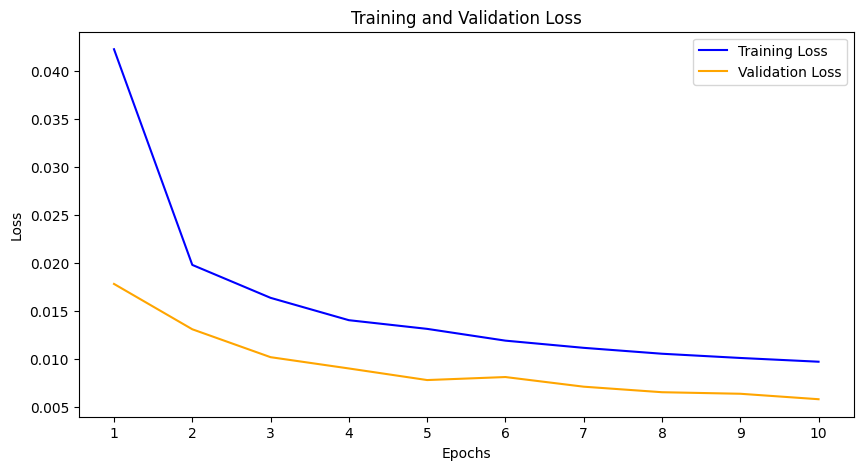

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', color='blue')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.legend()
plt.show()

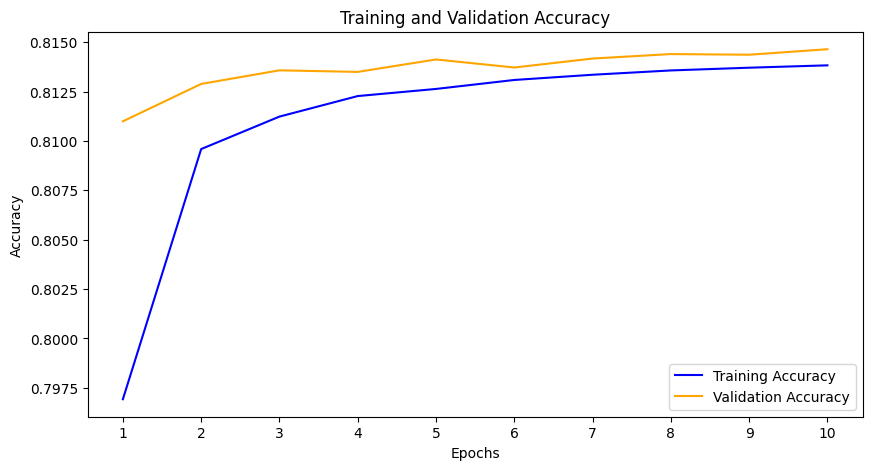

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history.history['accuracy']) + 1))
plt.legend()
plt.show()

The plots demonstrate a small generalization gap as well as a trend in loss reduction.The regularization terms are only applied while training the model on the training set, inflating the training loss which explains why it ends up being bigger.We also notice how the number of epochs is sufficient since in the last ones there is a tendency for metrics to be stabilized.

**Optimization History**

In [10]:
vis.plot_optimization_history(study)

**Plotting Parameter Importance:**

In [12]:
vis.plot_param_importances(study)

As expected, we notice that the the latent dimension has the biggest influence on the performance, since the bigger it is (30) the bigger the model's capacity to encapsulate information and successfully extract the most important features of the input.A larger number of layers with big filters ([32, 64, 128, 256]) as well is conducive to model's complexity improving the loss score.A rather small batch size is being used meaning the weights are being updated more often and generalize better.Since the dataset is not too complex, it can be learned quickly in small number of epochs (10).Lastly, dropout rate is moderate (0.5) leading to more robust representations and better generalization,(using batch normalization reduces the need for dropout too).

The model performs well with a rather small batch size and therefore needs a small number of epochs.

#  *To avoid overfitting we implement regularization techniques such as batch normalization and dropout in every layer as well as early stopping with patience = 3.*